In [1]:
import pickle
import pandas as pd
import numpy as np
from scipy import interp
from collections import defaultdict
from itertools import cycle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score, auc, precision_score, confusion_matrix
from sklearn.inspection import permutation_importance

from scipy.spatial import distance
from scipy.cluster import hierarchy

import matplotlib.pyplot as plt
from bokeh.plotting import show, save, output_notebook, output_file
import seaborn as sns
import zentables as zen

import time
import datetime

print(datetime.datetime.now())

2023-06-12 12:38:17.972609


In [2]:
path_data = '../data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220720.p'
fn_featureImp = path_data + 'featureImportance_binaryAll_s20220704.p'

# OUTPUTS
fn_trainingResults = path_data + 'trainingResults_binary80_s20230504.p'
fn_predictionsTraining  = path_data + 'predictionsTraining_binary_s20230504.xlsx'

fn_featureGrps_csv_supp = '../supplementaryFiles/csv_feature2grps_s20230504.csv'
fn_grp2feats = '../supplementaryFiles/csv_grp2feat_s20230504.csv'
fn_featureImportance_csv_supp = '../supplementaryFiles/csv_featureImportance_s20230504.csv'

fn_f_clustermap_thumb = '../figures/f_clustermap_thumb_s20230504.png'
fn_f_clustermap_allfeat = '../figures/f_clustermap_allfeat_s20230504.png'
fn_f_clustermap_redfeat = '../figures/f_clustermap_redfeat_s20230504.svg'
fn_figure_auc_thumb = '../figures/f_auroc_thumb_s20230504.svg'
fn_figure_auc_cv = '../figures/f_auroc_cv_s20230504.svg'
fn_figure_auc_training = '../figures/f_auroc_train_s20230504.svg'

fn_featKept = '../supplementaryFiles/csv_featuresUsed_s20230504.csv'
fn_top3feat = '../supplementaryFiles/csv_top3featureGrps_s20230504.csv'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

In [4]:
## number of features
dValue = 0.225

## reduce feature set

In [ ]:
# define current data
currFeatures = dict_data['df_zscoreFeatures_training']
tempMeta = dict_data['df_metadata']
currMeta = tempMeta[tempMeta.index.isin(currFeatures.index)]
currMeta['hvpg_corrected'] = currMeta['hvpg_corrected'].fillna(0).astype(int)
currMeta['hvpg_toPredict'] = currMeta['hvpg_corrected'].apply(lambda x: 0 if x < 10 else 1)

toPredict = currMeta['hvpg_toPredict']

display(currFeatures)
#display(currMeta)

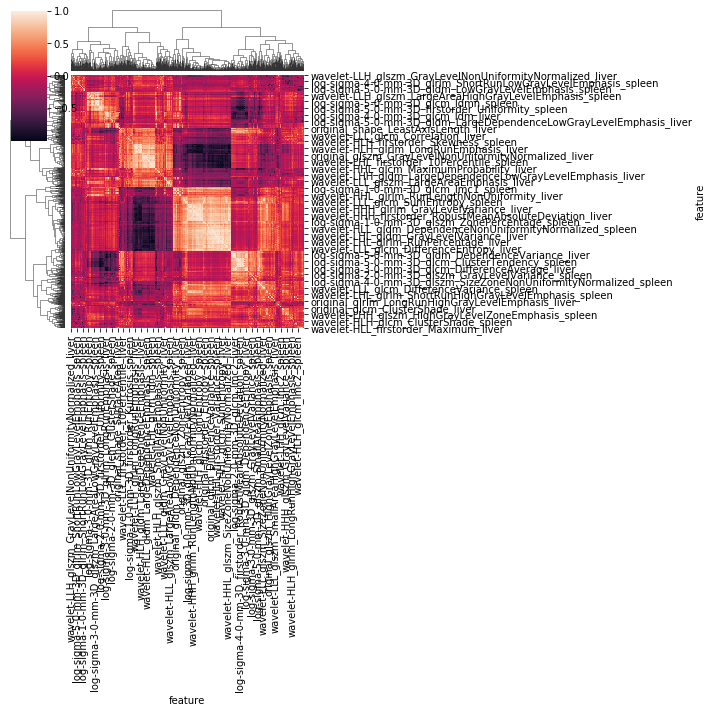

In [6]:
## identify redundant features

# retrieve clusters using fcluster 
df_featcorr = currFeatures.astype(float).corr(method='pearson')
d = hierarchy.distance.pdist(df_featcorr)
L = hierarchy.linkage(d, method='complete')
# 0.2 can be modified to retrieve more stringent or relaxed clusters (fewer clusters, increase number)
clusters = hierarchy.fcluster(L, dValue*d.max(), 'distance')

# store clusters in dictionary
featCluster_dict = defaultdict(list)
for i,cluster in enumerate(clusters):
    featCluster_dict[cluster].append(df_featcorr.index[i])

currPlt = sns.clustermap(df_featcorr, row_linkage=L, col_linkage=L)

In [7]:
print('total # of features:')
print(len(clusters))
print('# features used for model training:')
print(len(featCluster_dict))

total # of features:
2436
# features used for model training:
80


In [8]:
# load feature importances
with open(fn_featureImp, "rb") as input_file:
    forest_importances = pickle.load(input_file)

forest_importances

feature
original_shape_Elongation_liver                                 0.004791
original_shape_Flatness_liver                                   0.000787
original_shape_LeastAxisLength_liver                            0.000265
original_shape_MajorAxisLength_liver                            0.000727
original_shape_Maximum2DDiameterColumn_liver                    0.000979
                                                                  ...   
wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis_spleen     0.000124
wavelet-LLL_gldm_LowGrayLevelEmphasis_spleen                    0.000047
wavelet-LLL_gldm_SmallDependenceEmphasis_spleen                 0.000055
wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis_spleen    0.000046
wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis_spleen     0.000290
Length: 2436, dtype: float64

In [9]:
df_allimp = pd.DataFrame({'Feature': forest_importances.index, 
                          'Importance': forest_importances})

df_allimp[['pre', 'class', 'feat', 'organ']] = df_allimp['Feature'].str.split('_', expand=True)
df_allimp

,Feature,Importance,pre,class,feat,organ
feature,,,,,,
original_shape_Elongation_liver,original_shape_Elongation_liver,0.004791,original,shape,Elongation,liver
original_shape_Flatness_liver,original_shape_Flatness_liver,0.000787,original,shape,Flatness,liver
original_shape_LeastAxisLength_liver,original_shape_LeastAxisLength_liver,0.000265,original,shape,LeastAxisLength,liver
original_shape_MajorAxisLength_liver,original_shape_MajorAxisLength_liver,0.000727,original,shape,MajorAxisLength,liver
original_shape_Maximum2DDiameterColumn_liver,original_shape_Maximum2DDiameterColumn_liver,0.000979,original,shape,Maximum2DDiameterColumn,liver
...,...,...,...,...,...,...
wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEm...,0.000124,wavelet-LLL,gldm,LargeDependenceLowGrayLevelEmphasis,spleen
wavelet-LLL_gldm_LowGrayLevelEmphasis_spleen,wavelet-LLL_gldm_LowGrayLevelEmphasis_spleen,0.000047,wavelet-LLL,gldm,LowGrayLevelEmphasis,spleen
wavelet-LLL_gldm_SmallDependenceEmphasis_spleen,wavelet-LLL_gldm_SmallDependenceEmphasis_spleen,0.000055,wavelet-LLL,gldm,SmallDependenceEmphasis,spleen


In [10]:
print(df_allimp[['class']].value_counts())

class     
glcm          616
firstorder    504
glrlm         448
glszm         448
gldm          392
shape          28
dtype: int64


In [11]:
importances = list(forest_importances)
feat2keep = []
featClusterOrder = []

# list the most influential features
num2list = 10

top_idx = np.argsort(importances)[-num2list:]
top_values = ['{:.4f}'.format(importances[i]) for i in top_idx]

# make data frame to show top features and scores, and display
df_importances = pd.DataFrame({'Feature': currFeatures.columns[top_idx], 'Importance': top_values})

# for each cluster, check which feature is most important, and keep it for downstream model
for eaCluster in featCluster_dict:
    currFeature_i = [currFeatures.columns.get_loc(c) for c in featCluster_dict[eaCluster]]
    currImportances = [forest_importances[c] for c in currFeature_i]
    toKeep_i = currFeature_i[currImportances.index(max(currImportances))]
    feat2keep.append(currFeatures.columns[toKeep_i])
    featClusterOrder.append(eaCluster)    

In [12]:
df_featcorr_2keep = df_featcorr[feat2keep]
df_featcorr_2keep = df_featcorr_2keep[df_featcorr_2keep.index.isin(feat2keep)]

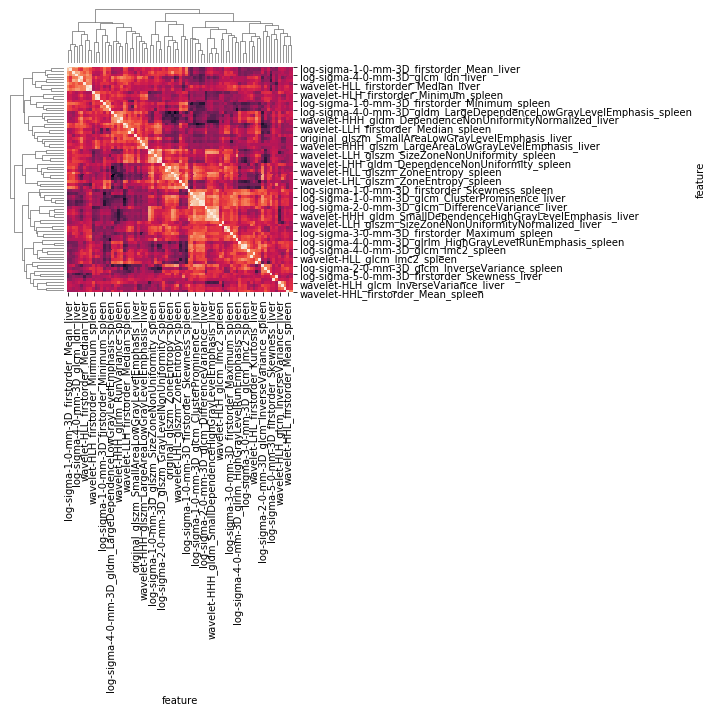

In [13]:
currPlt = sns.clustermap(df_featcorr_2keep)
currPlt.cax.set_visible(False)

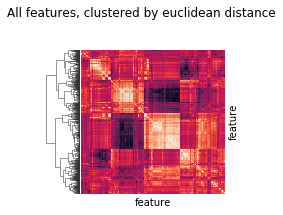

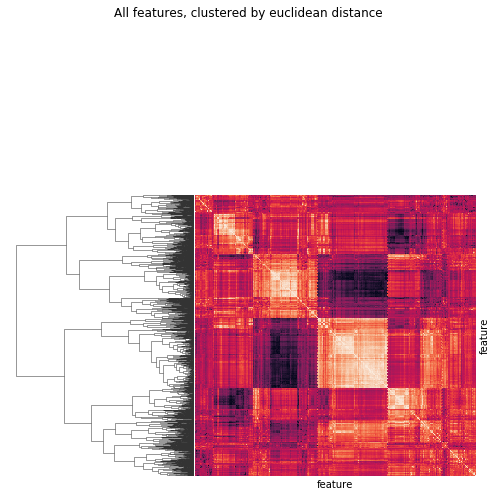

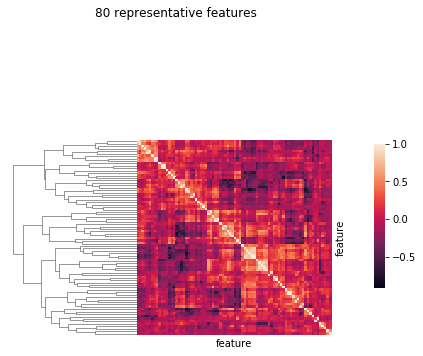

In [14]:
# without feature labels for paper
g = sns.clustermap(df_featcorr, row_linkage=L, col_linkage=L, 
                        yticklabels=False, xticklabels=False,
                        figsize=(3,3))
g.ax_col_dendrogram.set_visible(False)
g.cax.set_visible(False)
g.fig.suptitle('All features, clustered by euclidean distance')
plt.savefig(fn_f_clustermap_thumb, bbox_inches='tight')

g = sns.clustermap(df_featcorr, row_linkage=L, col_linkage=L, 
                        yticklabels=False, xticklabels=False,
                        dendrogram_ratio=0.4, figsize=(7,7))
g.ax_col_dendrogram.set_visible(False)
g.cax.set_visible(False)
g.fig.suptitle('All features, clustered by euclidean distance')
plt.savefig(fn_f_clustermap_allfeat, bbox_inches='tight')

f = sns.clustermap(df_featcorr_2keep, 
                   yticklabels=False, xticklabels=False,
                   dendrogram_ratio=0.4, figsize=(5,5))
f.ax_col_dendrogram.set_visible(False)
f.ax_cbar.set_position((1.05, .2, .03, .4))
f.fig.suptitle('80 representative features')
plt.savefig(fn_f_clustermap_redfeat, bbox_inches='tight')

In [15]:
currFeatures_2keep = currFeatures[feat2keep]

In [16]:
features = currFeatures_2keep
labels = toPredict

print(len(labels[labels == 0]))
print(len(labels[labels == 1]))
print(len(labels[labels == 2]))

183
270
0


In [17]:
## USING BEST!

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: scipy.interp is deprecated and will be removed in 

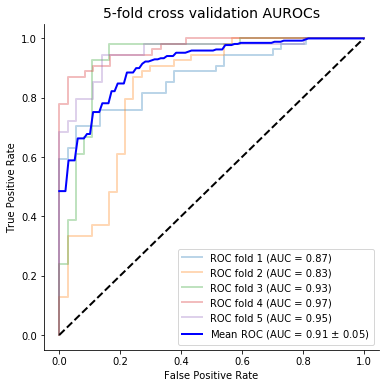

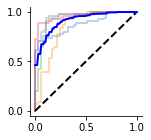

In [18]:
# #############################################################################
# Classification and ROC analysis for subset of features
features = currFeatures_2keep
labels = toPredict
x = features
y = labels

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier_roc_cv = RandomForestClassifier(bootstrap=True,
                                    max_depth=35, 
                                    max_features='auto',
                                    min_samples_leaf=4,
                                    min_samples_split=10, 
                                    n_estimators=100)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

i = 1
for train,test in cv.split(x,y):
    prediction = classifier_roc_cv.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5-fold cross validation AUROCs')
plt.legend(loc="lower right")

# save big for supplementary
plt.savefig(fn_figure_auc_cv)



####################
# thumbnail
fig, ax = plt.subplots(figsize=(2, 2))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

i = 1
for train,test in cv.split(x,y):
    prediction = classifier_roc_cv.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)


plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)
plt.yticks([0, 0.5, 1])
plt.xticks([0, 0.5, 1])

plt.savefig(fn_figure_auc_thumb)

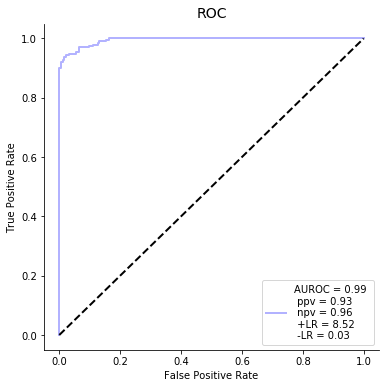

In [19]:
# #############################################################################
# Train classifier with validation data (no cross validation, keep this model!)
features = currFeatures_2keep
labels = toPredict
x = features
y = labels

# Train classifier
classifier_roc = RandomForestClassifier(bootstrap=True,
                                    max_depth=35, 
                                    max_features='auto',
                                    min_samples_leaf=4,
                                    min_samples_split=10, 
                                    n_estimators=100)

classifier_roc = classifier_roc.fit(x, y)
predClasses = classifier_roc.predict(x)
probabilities = classifier_roc.predict_proba(x)
predictions = probabilities[:,1]



tn, fp, fn, tp = confusion_matrix(y, predClasses).ravel()

ppv = tp / (tp+fp)
npv = tn / (tn+fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp+tn) / (tp+tn+fp+fn)

posLR = sensitivity / (1 - specificity)
negLR = (1 - sensitivity) / specificity

#
fpr, tpr, threshold = roc_curve(y, predictions)
roc_auc = auc(fpr, tpr)

predClasses = classifier_roc.predict(x)
precision = precision_score(y, predClasses)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

labelTxt = 'AUROC = %0.2f \n ppv = %0.2f \n npv = %0.2f \n +LR = %0.2f \n -LR = %0.2f' % (roc_auc, ppv, npv, posLR, negLR)

plt.plot(fpr, tpr, color='blue', lw=2, alpha=0.3, label=labelTxt)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

In [20]:
train_score = classifier_roc.predict_proba(features)
predClasses = classifier_roc.predict(features)

predictionsTraining = pd.DataFrame(data=train_score, columns=['p(grp0)', 'p(grp1)'])
predictionsTraining['hvpg_corrected']=list(currMeta['hvpg_corrected'])
predictionsTraining['grp']=list(labels)
predictionsTraining['pred_bin']=predClasses
predictionsTraining.index=features.index
predictionsTraining

# write to excel
predictionsTraining.to_excel(fn_predictionsTraining)

In [21]:
predictionsTraining

,p(grp0),p(grp1),hvpg_corrected,grp,pred_bin
0001,0.094940,0.905060,11,1,1
0002,0.448934,0.551066,6,0,1
0004,0.686890,0.313110,6,0,0
0005,0.458299,0.541701,7,0,1
0006,0.495024,0.504976,9,0,1
...,...,...,...,...,...
1136,0.971417,0.028583,0,0,0
1138,0.957918,0.042082,0,0,0
1139,0.899175,0.100825,0,0,0
1141,0.811055,0.188945,0,0,0


In [22]:
currFeatures_2keep

feature,wavelet-HHL_firstorder_Mean_liver,log-sigma-3-0-mm-3D_firstorder_Median_liver,wavelet-HLL_firstorder_Median_liver,wavelet-HHL_firstorder_Mean_spleen,log-sigma-3-0-mm-3D_glszm_SizeZoneNonUniformityNormalized_spleen,log-sigma-4-0-mm-3D_glcm_Imc2_spleen,original_firstorder_Entropy_spleen,wavelet-HLL_glcm_Imc2_spleen,wavelet-HLH_glcm_Imc2_spleen,original_glszm_SmallAreaLowGrayLevelEmphasis_liver,...,log-sigma-4-0-mm-3D_glrlm_HighGrayLevelRunEmphasis_spleen,log-sigma-1-0-mm-3D_glszm_SizeZoneNonUniformity_spleen,wavelet-LHH_glszm_LargeAreaHighGrayLevelEmphasis_spleen,log-sigma-2-0-mm-3D_glcm_InverseVariance_spleen,wavelet-LLH_gldm_SmallDependenceLowGrayLevelEmphasis_spleen,log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_spleen,wavelet-HLH_firstorder_Minimum_spleen,log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_spleen,log-sigma-3-0-mm-3D_glcm_Imc2_spleen,log-sigma-3-0-mm-3D_firstorder_Maximum_spleen
0001,0.317962,-2.642243,-0.408567,0.439578,0.689669,-0.434598,-0.96895,-0.120052,0.526841,0.618036,...,0.811595,1.065648,1.58407,-1.520699,-0.524928,3.11007,-1.49101,2.075521,-0.579914,0.282407
0002,-0.355644,-1.671251,0.134806,-1.498802,-1.234392,-1.264677,0.958141,-1.361576,-1.477334,-0.590841,...,-1.79778,-0.290275,-0.575897,0.802918,1.456231,0.135224,0.915311,-0.660259,-0.890952,-2.155246
0004,-0.745664,0.592689,0.107278,2.484271,0.930013,0.222211,-0.908395,0.5054,-0.754518,1.442235,...,-0.387565,-0.619853,-0.434063,-0.482508,-0.774801,-0.096488,0.732748,-0.340157,0.236732,-0.482704
0005,0.194069,0.00719,0.307001,-0.453893,-0.568171,-1.057983,0.465234,-0.648319,-0.383122,-0.544151,...,-0.767523,-0.697996,-0.008849,-0.337956,-0.325806,-0.795056,-0.666349,-0.814253,-1.729752,0.169505
0006,0.318691,0.251678,-0.270942,0.285167,1.716413,0.66049,-0.35738,0.381645,-0.476629,-0.233108,...,0.896774,-0.066132,-0.148046,-0.503378,-0.635705,0.694349,-0.849951,0.924537,0.549756,0.919291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,-0.369869,0.40947,-1.027506,1.022491,1.783925,0.435534,0.790516,0.494971,-0.416775,-0.812821,...,0.609457,-0.532373,-0.674222,1.97263,0.369046,-0.841916,1.417974,-0.780611,0.93578,-0.083432
1138,0.006201,0.857107,1.087208,-0.458509,0.532604,0.978059,0.623776,-0.792629,-0.384476,-0.5631,...,-0.397248,-0.545085,-0.275871,0.840516,0.048014,-0.368201,-0.784234,-0.748485,1.079173,1.918981
1139,0.963062,0.674125,0.311917,1.323992,0.860243,1.153915,0.482561,0.094468,-0.539927,-1.148384,...,0.889819,-0.585081,-0.286406,1.692224,-0.550756,-0.21653,0.663205,-0.19711,1.417091,-1.818047
1141,0.25074,0.889666,-0.485204,-0.840365,1.902472,0.538107,-0.830093,-0.142908,-1.219817,-0.543896,...,0.750074,-0.682971,-0.189747,-0.338195,-0.646251,-0.233093,1.282167,-0.203839,0.81955,0.106373


In [23]:
## use feature permutation to identify most important feature of model

train_features = currFeatures_2keep
train_labels = toPredict
rf = classifier_roc
rf.fit(train_features, train_labels); 

start_time = time.time()
result_subset = permutation_importance(
    rf, train_features, train_labels, n_repeats=100, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances_subset = pd.Series(result_subset.importances_mean, index=train_features.columns)

Elapsed time to compute the importances: 49.509 seconds


In [24]:
forest_importances_subset

feature
wavelet-HHL_firstorder_Mean_liver                                      -0.000353
log-sigma-3-0-mm-3D_firstorder_Median_liver                             0.005872
wavelet-HLL_firstorder_Median_liver                                     0.002958
wavelet-HHL_firstorder_Mean_spleen                                      0.001280
log-sigma-3-0-mm-3D_glszm_SizeZoneNonUniformityNormalized_spleen        0.004547
                                                                          ...   
log-sigma-2-0-mm-3D_glrlm_LongRunHighGrayLevelEmphasis_spleen           0.003400
wavelet-HLH_firstorder_Minimum_spleen                                   0.004283
log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis_spleen    0.003157
log-sigma-3-0-mm-3D_glcm_Imc2_spleen                                    0.001987
log-sigma-3-0-mm-3D_firstorder_Maximum_spleen                           0.002804
Length: 80, dtype: float64

In [56]:
df_impFeatUsed = pd.DataFrame({'Feature': forest_importances_subset.index, 
                          'Importance': forest_importances_subset})

df_impFeatUsed[['pre', 'class', 'feat', 'organ']] = df_allimp['Feature'].str.split('_', expand=True)
df_impFeatUsed.set_index('Feature').sort_values('Importance').zen.pretty()



,Importance,pre,class,feat,organ
wavelet-LHH_gldm_DependenceNonUniformity_spleen,-0.001082,wavelet-LHH,gldm,DependenceNonUniformity,spleen
wavelet-LLH_firstorder_Median_spleen,-0.000751,wavelet-LLH,firstorder,Median,spleen
wavelet-HHL_firstorder_Mean_liver,-0.000353,wavelet-HHL,firstorder,Mean,liver
log-sigma-1-0-mm-3D_glszm_SizeZoneNonUniformity_liver,-0.000221,log-sigma-1-0-mm-3D,glszm,SizeZoneNonUniformity,liver
log-sigma-1-0-mm-3D_glszm_LargeAreaEmphasis_liver,-0.000110,log-sigma-1-0-mm-3D,glszm,LargeAreaEmphasis,liver
wavelet-HLH_glcm_InverseVariance_liver,0.000662,wavelet-HLH,glcm,InverseVariance,liver
wavelet-LLH_gldm_SmallDependenceLowGrayLevelEmphasis_spleen,0.000817,wavelet-LLH,gldm,SmallDependenceLowGrayLevelEmphasis,spleen
log-sigma-1-0-mm-3D_firstorder_Skewness_spleen,0.000861,log-sigma-1-0-mm-3D,firstorder,Skewness,spleen
log-sigma-1-0-mm-3D_glszm_SizeZoneNonUniformity_spleen,0.000949,log-sigma-1-0-mm-3D,glszm,SizeZoneNonUniformity,spleen
wavelet-LLH_glcm_DifferenceVariance_spleen,0.000949,wavelet-LLH,glcm,DifferenceVariance,spleen


In [26]:
# not really interesting, these are just the representative features of the 80groups
print(df_impFeatUsed[['class']].value_counts())

class     
firstorder    24
glszm         19
glcm          18
gldm          13
glrlm          5
shape          1
dtype: int64


In [27]:
## Identify important features

In [28]:
# list the most influential features
num2list = 10

importances = list(forest_importances_subset)
top_idx = np.argsort(importances)[-num2list:]
top_values = ['{:.4f}'.format(importances[i]) for i in top_idx]

df_importances = pd.DataFrame({'Feature': currFeatures_2keep.columns[top_idx], 'Importance': top_values})

df_importances = df_importances.sort_values(by=['Importance'], ascending=False)

In [29]:
df_importances

,Feature,Importance
9,log-sigma-4-0-mm-3D_gldm_LargeDependenceLowGra...,0.0087
8,wavelet-HLL_glcm_Correlation_spleen,0.0083
7,wavelet-HHH_gldm_SmallDependenceHighGrayLevelE...,0.0078
6,log-sigma-2-0-mm-3D_firstorder_Median_liver,0.0072
5,wavelet-HHH_gldm_DependenceNonUniformityNormal...,0.0070
4,log-sigma-1-0-mm-3D_glcm_ClusterProminence_spleen,0.0065
2,log-sigma-4-0-mm-3D_glrlm_HighGrayLevelRunEmph...,0.0062
3,log-sigma-4-0-mm-3D_firstorder_Maximum_liver,0.0062
0,wavelet-LHL_firstorder_Kurtosis_liver,0.0060
1,original_glszm_ZoneEntropy_spleen,0.0060


In [30]:
temp_i = feat2keep.index(df_importances['Feature'][9])
temp_ii = featClusterOrder[temp_i]
temp_list = featCluster_dict[featClusterOrder[temp_ii]]
print(len(featCluster_dict[featClusterOrder[temp_ii]]))

temp_df = pd.DataFrame({'Feature': temp_list})
temp_df[['pre', 'class', 'feat', 'organ']] = temp_df['Feature'].str.split('_', expand=True)
temp_df
temp_df[['class', 'organ']].value_counts()
temp_df[['class','feat', 'organ']].value_counts()

21


class       feat                                 organ 
gldm        SmallDependenceLowGrayLevelEmphasis  liver     7
firstorder  Skewness                             liver     3
                                                 spleen    3
            Median                               liver     2
glcm        Imc1                                 liver     2
                                                 spleen    2
firstorder  Mean                                 liver     1
            Median                               spleen    1
dtype: int64

In [31]:
temp_i = feat2keep.index(df_importances['Feature'][8])
temp_ii = featClusterOrder[temp_i]
temp_list = featCluster_dict[featClusterOrder[temp_ii]]
print(len(featCluster_dict[featClusterOrder[temp_ii]]))

temp_df1 = pd.DataFrame({'Feature': temp_list})
temp_df1[['pre', 'class', 'feat', 'organ']] = temp_df1['Feature'].str.split('_', expand=True)
temp_df1
temp_df1[['class', 'organ']].value_counts()
temp_df1[['class','feat', 'organ']].value_counts()

27


class       feat                     organ
glszm       GrayLevelNonUniformity   liver    6
            SizeZoneNonUniformity    liver    6
glrlm       RunLengthNonUniformity   liver    5
gldm        DependenceNonUniformity  liver    4
firstorder  Energy                   liver    3
            TotalEnergy              liver    3
dtype: int64

In [32]:
temp_i = feat2keep.index(df_importances['Feature'][7])
temp_ii = featClusterOrder[temp_i]
temp_list = featCluster_dict[featClusterOrder[temp_ii]]
print(len(featCluster_dict[featClusterOrder[temp_ii]]))

temp_df2 = pd.DataFrame({'Feature': temp_list})
temp_df2[['pre', 'class', 'feat', 'organ']] = temp_df2['Feature'].str.split('_', expand=True)
temp_df2
temp_df2[['class', 'organ']].value_counts()
temp_df2[['class','feat', 'organ']].value_counts()

107


class       feat                               organ 
firstorder  Mean                               spleen    8
gldm        DependenceNonUniformity            spleen    7
            GrayLevelNonUniformity             spleen    6
firstorder  Median                             spleen    6
glrlm       GrayLevelNonUniformity             spleen    5
glszm       ZoneVariance                       spleen    4
            LargeAreaLowGrayLevelEmphasis      spleen    4
            LargeAreaEmphasis                  spleen    4
firstorder  10Percentile                       spleen    4
            Kurtosis                           spleen    4
            Uniformity                         spleen    4
glcm        Idmn                               spleen    3
            Id                                 spleen    3
glszm       LargeAreaHighGrayLevelEmphasis     spleen    3
glrlm       RunVariance                        spleen    3
glcm        Idn                                spleen    3
gl

In [33]:
temp_all = pd.concat([temp_df, temp_df1, temp_df2], ignore_index=True)
temp_all[['class', 'organ']].value_counts()


class       organ 
firstorder  spleen    34
glcm        spleen    20
gldm        spleen    19
glrlm       spleen    16
glszm       spleen    15
firstorder  liver     12
glszm       liver     12
gldm        liver     11
shape       spleen     9
glrlm       liver      5
glcm        liver      2
dtype: int64

In [34]:
# number of features in the top 3 feature groups
len(temp_all)

155

In [35]:
# number of liver/spleen features in the top 3 feature groups
print(temp_all[['organ']].value_counts())

# number of class features in the top 3 feature groups
print(temp_all[['class']].value_counts())

organ 
spleen    113
liver      42
dtype: int64
class     
firstorder    46
gldm          30
glszm         27
glcm          22
glrlm         21
shape          9
dtype: int64


In [36]:
print(temp_all[['class','feat', 'organ']].value_counts())

class       feat                                 organ 
firstorder  Mean                                 spleen    8
            Median                               spleen    7
gldm        SmallDependenceLowGrayLevelEmphasis  liver     7
            DependenceNonUniformity              spleen    7
            GrayLevelNonUniformity               spleen    6
glszm       SizeZoneNonUniformity                liver     6
            GrayLevelNonUniformity               liver     6
glrlm       RunLengthNonUniformity               liver     5
            GrayLevelNonUniformity               spleen    5
gldm        DependenceNonUniformity              liver     4
glszm       ZoneVariance                         spleen    4
            LargeAreaLowGrayLevelEmphasis        spleen    4
            LargeAreaEmphasis                    spleen    4
firstorder  10Percentile                         spleen    4
            Kurtosis                             spleen    4
            Uniformity       

In [37]:
# save
trainingResults = {}
trainingResults['importances_all']=forest_importances
trainingResults['importances_kept']=forest_importances_subset
trainingResults['feat2keep']=feat2keep
trainingResults['groups']=featCluster_dict
trainingResults['model_rf_ovr']=classifier_roc
#trainingResults['model_rf80_f1']=classifier_f1
#trainingResults['model_rf_blind']=classifier

pickle.dump(trainingResults, open(fn_trainingResults, 'wb'))

# save data for supplementary
forest_importances.to_csv(fn_featureImportance_csv_supp)

In [38]:
# feature to group CSV
temp_tuples = []
for eaGrp in featCluster_dict:
    for eaItem in featCluster_dict[eaGrp]:
        temp_tuples.append((eaItem, eaGrp))
df_featureGroups = pd.DataFrame.from_records(temp_tuples, columns=['Feature', 'Group']).sort_values('Feature')

df_featureGroups.to_csv(fn_featureGrps_csv_supp, index=False)

In [39]:
df_featureGroups

,Feature,Group
1012,log-sigma-1-0-mm-3D_firstorder_10Percentile_liver,29
1265,log-sigma-1-0-mm-3D_firstorder_10Percentile_sp...,31
129,log-sigma-1-0-mm-3D_firstorder_90Percentile_liver,51
280,log-sigma-1-0-mm-3D_firstorder_90Percentile_sp...,51
749,log-sigma-1-0-mm-3D_firstorder_Energy_liver,47
...,...,...
1010,wavelet-LLL_glszm_ZoneEntropy_spleen,67
260,wavelet-LLL_glszm_ZonePercentage_liver,51
397,wavelet-LLL_glszm_ZonePercentage_spleen,51
993,wavelet-LLL_glszm_ZoneVariance_liver,38


In [40]:
# group to feature CSV
toWrite = dict(featCluster_dict)

with open(fn_grp2feats, 'w') as f:
    f.write('FeatureGroup, Features\n')
    [f.write('{0},{1}\n'.format(key, value)) for key, value in sorted(toWrite.items())]

In [41]:
len(featCluster_dict)

80

In [42]:
# write csv for 80 features used in model
toWrite = pd.DataFrame(trainingResults['feat2keep'], columns=["features in model"])
toWrite.to_csv(fn_featKept, index=False)

In [43]:
temp_all

,Feature,pre,class,feat,organ
0,original_glcm_Imc1_liver,original,glcm,Imc1,liver
1,original_gldm_SmallDependenceLowGrayLevelEmpha...,original,gldm,SmallDependenceLowGrayLevelEmphasis,liver
2,wavelet-LHL_firstorder_Skewness_liver,wavelet-LHL,firstorder,Skewness,liver
3,wavelet-LHL_gldm_SmallDependenceLowGrayLevelEm...,wavelet-LHL,gldm,SmallDependenceLowGrayLevelEmphasis,liver
4,wavelet-LHH_firstorder_Median_liver,wavelet-LHH,firstorder,Median,liver
...,...,...,...,...,...
150,wavelet-HHH_glrlm_GrayLevelNonUniformity_spleen,wavelet-HHH,glrlm,GrayLevelNonUniformity,spleen
151,wavelet-HHH_gldm_DependenceNonUniformity_spleen,wavelet-HHH,gldm,DependenceNonUniformity,spleen
152,wavelet-HHH_gldm_GrayLevelNonUniformity_spleen,wavelet-HHH,gldm,GrayLevelNonUniformity,spleen
153,wavelet-LLL_firstorder_Energy_spleen,wavelet-LLL,firstorder,Energy,spleen


In [57]:
temp_all.zen.pretty()

,Feature,pre,class,feat,organ
0,original_glcm_Imc1_liver,original,glcm,Imc1,liver
1,original_gldm_SmallDependenceLowGrayLevelEmphasis_liver,original,gldm,SmallDependenceLowGrayLevelEmphasis,liver
2,wavelet-LHL_firstorder_Skewness_liver,wavelet-LHL,firstorder,Skewness,liver
3,wavelet-LHL_gldm_SmallDependenceLowGrayLevelEmphasis_liver,wavelet-LHL,gldm,SmallDependenceLowGrayLevelEmphasis,liver
4,wavelet-LHH_firstorder_Median_liver,wavelet-LHH,firstorder,Median,liver
5,wavelet-LHH_gldm_SmallDependenceLowGrayLevelEmphasis_liver,wavelet-LHH,gldm,SmallDependenceLowGrayLevelEmphasis,liver
6,wavelet-HLL_firstorder_Skewness_liver,wavelet-HLL,firstorder,Skewness,liver
7,wavelet-HLL_gldm_SmallDependenceLowGrayLevelEmphasis_liver,wavelet-HLL,gldm,SmallDependenceLowGrayLevelEmphasis,liver
8,wavelet-HLH_firstorder_Median_liver,wavelet-HLH,firstorder,Median,liver
9,wavelet-HLH_gldm_SmallDependenceLowGrayLevelEmphasis_liver,wavelet-HLH,gldm,SmallDependenceLowGrayLevelEmphasis,liver


In [44]:
# write csv for features in the top 3 feature groups
temp_all.to_csv(fn_top3feat, index=False)

In [45]:
print(datetime.datetime.now())

2023-06-12 12:40:07.873713
